# Gaussian Mixture Model

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_ids,year,pseudo_year,region_codes,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,pseudo_bridge_year,...,connect_mainland_year,after_treatment_mainland,income,area_km2,distance_m,log_pop,pop_star,log_pop_star,time_since_treatment,is_already_treated
0,67,1970,1970,32202,32,NaN,1,1,1999,1999,...,1999,0,NaN,0.28,615.0,NaN,NaN,NaN,-29,0
1,67,1975,1975,32202,32,NaN,1,1,1999,1999,...,1999,0,NaN,0.28,615.0,NaN,NaN,NaN,-24,0
2,67,1980,1980,32202,32,NaN,1,1,1999,1999,...,1999,0,NaN,0.28,615.0,NaN,NaN,NaN,-19,0
3,67,1985,1985,32202,32,NaN,1,1,1999,1999,...,1999,0,4.243674e+07,0.28,615.0,NaN,NaN,NaN,-14,0
4,67,1990,1990,32202,32,NaN,1,1,1999,1999,...,1999,0,4.786833e+07,0.28,615.0,NaN,NaN,NaN,-9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,226,2000,2000,39424,39,398.0,1,1,1957,1957,...,1957,1,5.113370e+02,0.56,110.0,5.986452,-3554.926407,-17.541704,43,1
1859,226,2005,2005,39424,39,365.0,1,1,1957,1957,...,1957,1,4.533435e+02,0.56,110.0,5.899897,-3414.990237,-17.543261,48,1
1860,226,2010,2010,39424,39,343.0,1,1,1957,1957,...,1957,1,3.903833e+02,0.56,110.0,5.837730,-3249.786622,-17.453348,53,1
1861,226,2015,2015,39424,39,284.0,1,1,1957,1957,...,1957,1,4.064721e+02,0.56,110.0,5.648974,-3096.788109,-17.503871,58,1


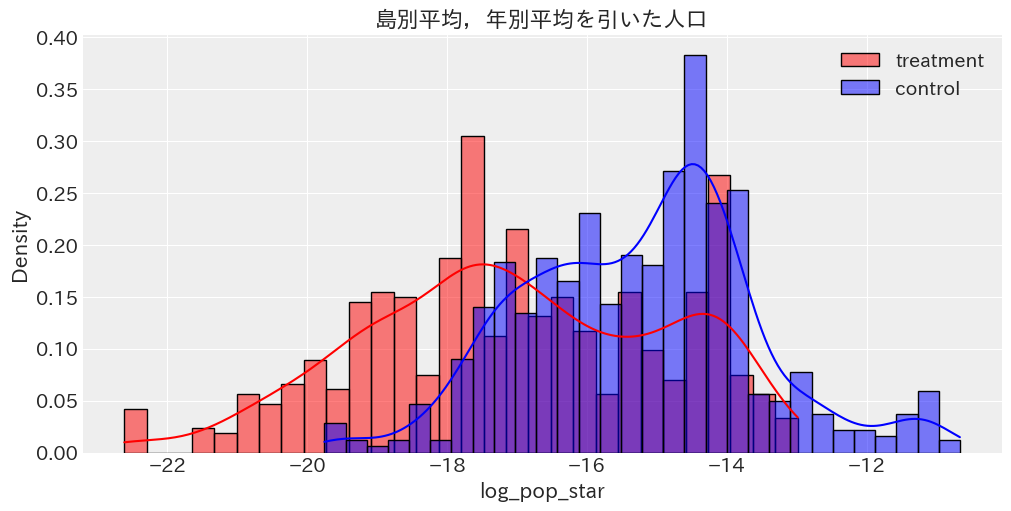

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['log_pop_star'][df['treatment_group'] == 1], bins=30, kde=True, stat='density', color='red', label='treatment')
sns.histplot(df['log_pop_star'][df['treatment_group'] == 0], bins=30, kde=True, stat='density', color='blue', label='control')
plt.title('島別平均，年別平均を引いた人口')
plt.legend()
plt.show()

In [17]:
k = 2

COORDS = {
    'obs_id': df.index,
    'cluster': range(k)
}

with pm.Model(coords=COORDS) as model:
    # data
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors

    # fixed effects
    beta = pm.Normal(
        'beta',
        mu=0,
        sigma=1,
        dims='cluster'
    )

    # expectation
    mu = beta * treatment

    # likelihood
    sigma = pm.HalfCauchy('sigma', beta=1, dims='cluster')
    weights = pm.Dirichlet('weights', a=np.ones(k), dims='cluster')

    y_obs = pm.NormalMixture(
        'y_obs',
        w=weights,
        comp_dists=[pm.Normal.dist(mu=mu[i], sigma=sigma[i]) for i in range(k)],
        observed=df['log_pop_star']
    )

pm.model_to_graphviz(model)

TypeError: NormalMixture.__new__() missing 1 required positional argument: 'mu'